# Processing GPU Data with Python Operators

This example shows you how to use the `PythonFunction` operator on a GPU. For an introduction and general information about Python operators family see the [Python Operators](./python_operator.ipynb) section.

Although Python operators are not designed to be fast, it might be useful to run them on a GPU, for example, when we want to introduce a custom operation to an existing GPU pipeline. For this purpose, all operators in the `PythonFunction` family have their GPU variants.

For the `TorchPythonFunction` and `DLTensorPythonFunction` operators data formats on which they operate stay the same as for the CPU, PyTorch tensors in the former, and [DLPack](https://github.com/dmlc/dlpack) tensors in the latter. For the GPU `PythonFunction`, inputs and outputs of the implementation function are [CuPy](https://cupy.chainer.org/) arrays.

## CuPy Operations
Since the *CuPy* arrays API is similar to the API in NumPy, we can implement the same operation that we defined in the CPU example nearly without any code changes. 

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy
import cupy


def edit_images(image1, image2):
    assert image1.shape == image2.shape
    h, w, c = image1.shape
    y, x = cupy.ogrid[0:h, 0:w]
    mask = (x - w / 2) ** 2 + (y - h / 2) ** 2 > h * w / 9
    result1 = cupy.copy(image1)
    result1[mask] = image2[mask]
    result2 = cupy.copy(image2)
    result2[mask] = image1[mask]
    return result1, result2

Another way to define a GPU function with *CuPy* is to write a CUDA kernel. Here, we present a simple kernel that  interleaves channels of the two images. Refer to the *CuPy* [documentation](https://docs-cupy.chainer.org/en/stable/tutorial/kernel.html) for more information.

In [2]:
mix_channels_kernel = cupy.ElementwiseKernel(
    "uint8 x, uint8 y", "uint8 z", "z = (i % 3) ? x : y", "mix_channels"
)

<div class="alert alert-block alert-warning">
<b>Warning</b>

When the pipeline has conditional execution enabled, additional steps must be taken to prevent the `function` from being rewritten by AutoGraph.
There are two ways to achieve this:
1. Define the function at global scope (i.e. outside of ``pipeline_def`` scope).
2. If function is a result of another "factory" function, then the factory function must be defined outside pipeline definition function and decorated with `<nvidia.dali.pipeline.do_not_convert>`.


More details can be found in `nvidia.dali.pipeline.do_not_convert` documentation.
</div>

## Defining a Pipeline
We define a pipeline like the pipeline that is used in the [Python Operators](./python_operator.ipynb) section. To move the execution from a CPU to a GPU, we only need to change operators' device arguments. It is also the only difference in usage of the `PythonFunction` operators. 

In [3]:
image_dir = "../data/images"
batch_size = 4

python_function_pipe = Pipeline(
    batch_size=batch_size,
    num_threads=4,
    device_id=0,
    exec_async=False,
    exec_pipelined=False,
    seed=99,
)

with python_function_pipe:
    input1, _ = fn.readers.file(file_root=image_dir, random_shuffle=True)
    input2, _ = fn.readers.file(file_root=image_dir, random_shuffle=True)
    im1, im2 = fn.decoders.image(
        [input1, input2], device="mixed", output_type=types.RGB
    )
    res1, res2 = fn.resize([im1, im2], device="gpu", resize_x=300, resize_y=300)
    out1, out2 = fn.python_function(
        res1, res2, device="gpu", function=edit_images, num_outputs=2
    )
    out3 = fn.python_function(
        res1, res2, device="gpu", function=mix_channels_kernel
    )
    python_function_pipe.set_outputs(out1, out2, out3)

## Running the Pipeline and Visualizing the Results
We can run the pipeline and show the results in similar way to the CPU example. 

**Note:** Before you try to plot them, remember to move the output batches to the host memory.

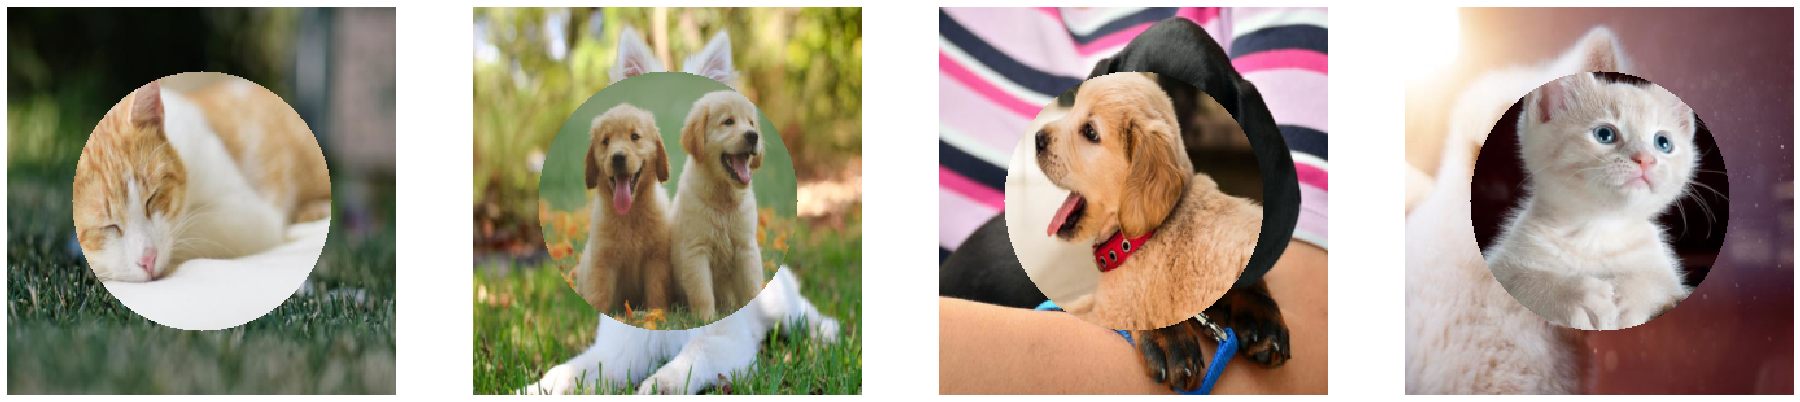

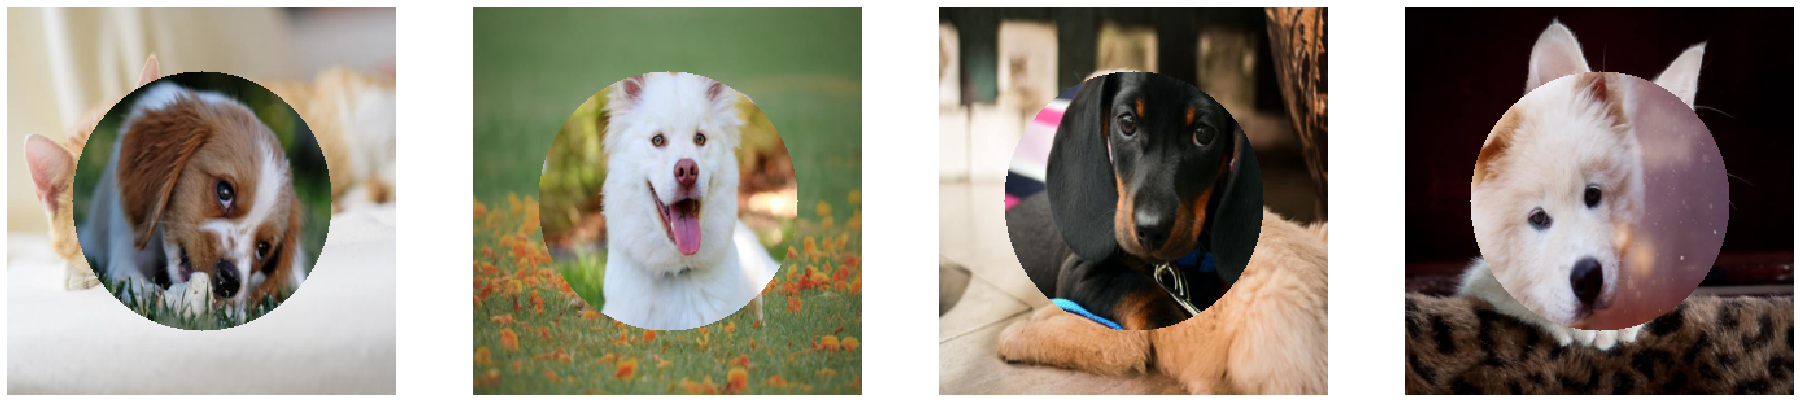

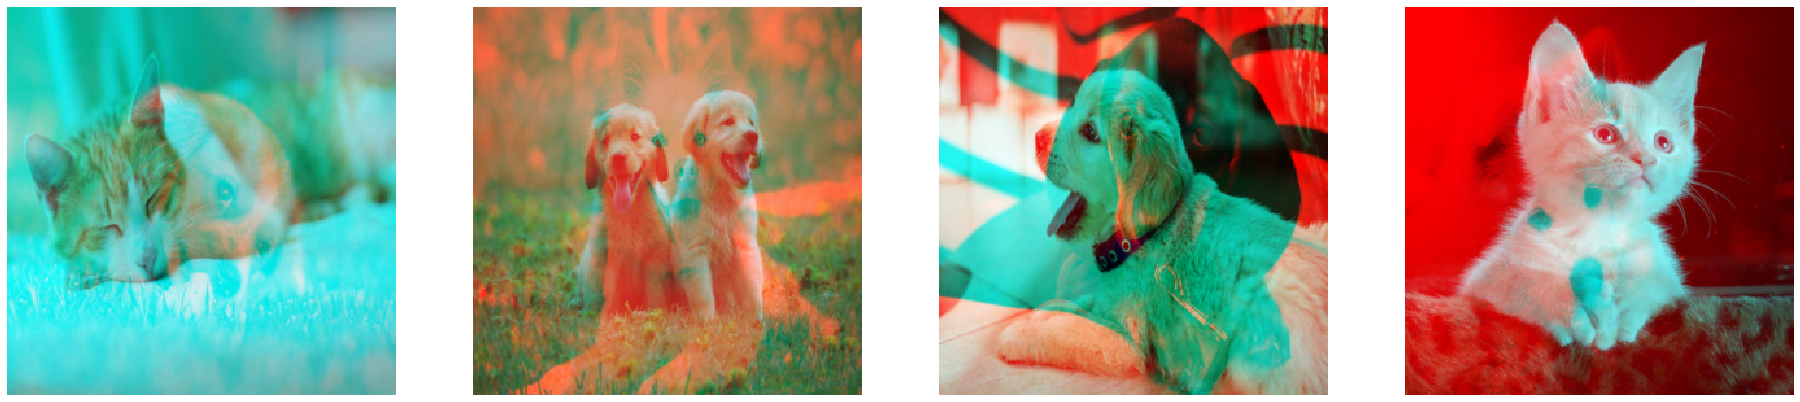

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm

%matplotlib inline

batch_size = 4


def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))


python_function_pipe.build()
ims1, ims2, ims3 = python_function_pipe.run()

show_images(ims1.as_cpu())
show_images(ims2.as_cpu())
show_images(ims3.as_cpu())

## Advanced: Device Synchronization in the DLTensorPythonFunction
When using `PythonFunction` or `TorchPythonFunction`, we do not have to synchronize our GPU code with the rest of the DALI pipeline, because the synchronization is handled by the operator. The `DLTensorPythonFunction` operator, on the other hand leaves the device synchronization to the user. 

**Note:** The synchronization proces may vary for different frameworks and libraries. 

As an example, we will write a wrapper around a previously implemented `mix_channels_kernel` that converts DLPack tensors to *CuPy* arrays and handles the stream synchronization. 


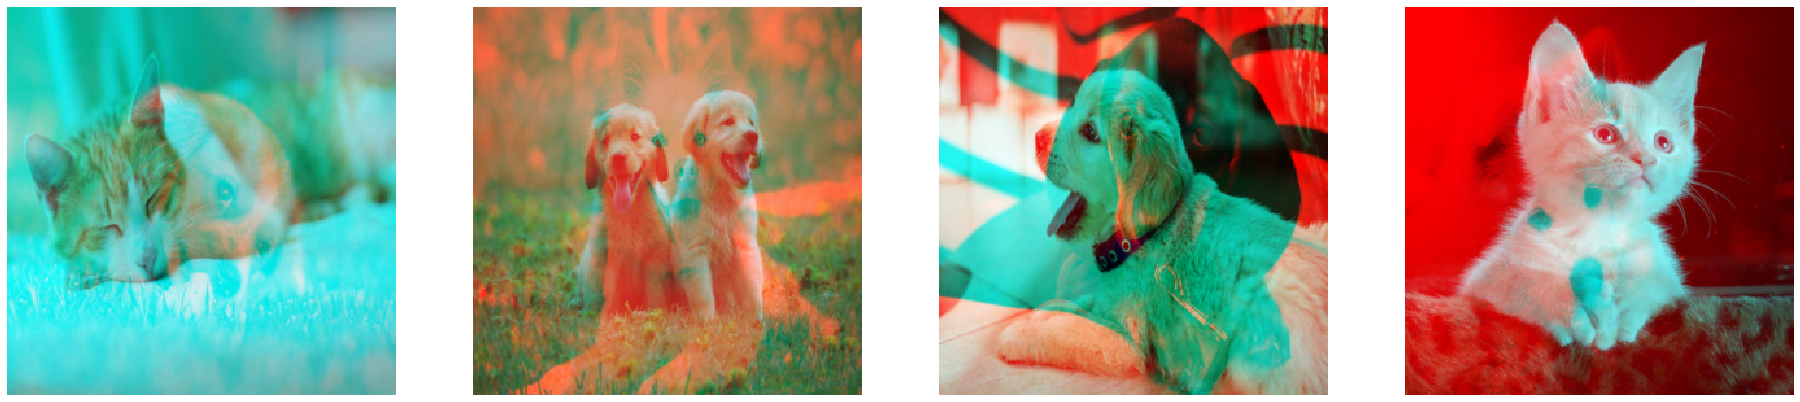

In [5]:
def mix_channels_wrapper(tensor1, tensor2):
    array1 = cupy.fromDlpack(tensor1)
    array2 = cupy.fromDlpack(tensor2)
    result = mix_channels_kernel(array1, array2)
    cupy.cuda.get_current_stream().synchronize()
    return result.toDlpack()


dltensor_function_pipe = Pipeline(
    batch_size=batch_size,
    num_threads=4,
    device_id=0,
    exec_async=False,
    exec_pipelined=False,
    seed=99,
)

with dltensor_function_pipe:
    input1, _ = fn.readers.file(file_root=image_dir, random_shuffle=True)
    input2, _ = fn.readers.file(file_root=image_dir, random_shuffle=True)
    im1, im2 = fn.decoders.image(
        [input1, input2], device="mixed", output_type=types.RGB
    )
    res1, res2 = fn.resize([im1, im2], device="gpu", resize_x=300, resize_y=300)
    out = fn.dl_tensor_python_function(
        res1,
        res2,
        device="gpu",
        function=mix_channels_wrapper,
        synchronize_stream=True,
        batch_processing=False,
    )
    dltensor_function_pipe.set_outputs(out)

dltensor_function_pipe.build()
(ims,) = dltensor_function_pipe.run()

show_images(ims.as_cpu())

The result is the same as after running `mix_channels_kernel` with `PythonFunction`. To correctly synchronize device code in `DLTensorPythonFunction` ensure that the folowing conditions are met:

* All the preceding **DALI** GPU work is completed before the start of a provided function. 
* The work that we schedule in the provided function is completed before we return the results. 

The first condition is warranted by the `synchronize_stream=True` flag (set to `True` by default). The user is responsible for providing the second part. In the example above the synchronization is achieved by adding the `cupy.cuda.get_current_stream().synchronize()` line.